> **Your turn now**: use ```ogrid``` to design a circular mask for the target and an annular mask for the background, and use it to perform photometry on SZ Lyn. Compare the SNR you obtain in this case with the one obtained with a square mask.

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
from utils import *

# Load science image and find its maximum
sci = fits.open('sci_2015/Reduced-001.fits')[0]


# Extract a sub-image centered on the image maximum
reg = np.s_[200:430,350:580]
sub_img = sci.data[reg]
x_max, y_max = extrema(sub_img)

# Define row and column indexes centered on the maximum
shape = sub_img.shape
rows, cols = np.ogrid[-y_max:shape[0]-y_max, -x_max:shape[1]-x_max]

# Define a circular mask for the target and a annular mask for the background
rad = [10.5,20,70]
#rad = [10, 20, 30]
targ_mask = rows**2+cols**2<rad[0]**2    
bkg_mask = np.logical_and(rows**2+cols**2>rad[-2]**2,rows**2+cols**2<rad[-1]**2) 

# Apply the masks
inside = np.copy(sub_img)
outside = np.copy(sub_img)
inside[~targ_mask] = np.nan
outside[~bkg_mask] = np.nan
npix = np.nansum(targ_mask)

# Estimate the background
outside_mean = np.nanmean(outside)
outside_std = np.nanstd(outside)
gain = 0.6  # ph/ADU
bkg = outside_mean*gain
bkg_noise = outside_std*gain
inside_bkgsub = inside-outside_mean
subtr_fact = np.nansum(targ_mask)/np.nansum(bkg_mask)
print(np.nansum(targ_mask),np.nansum(bkg_mask))

# Compute flux and error
ron = 28.8
flux = np.nansum(inside_bkgsub)*gain
error = np.sqrt(flux + 2*ron**2*npix + (1+subtr_fact)*bkg_noise**2*npix)
snr = flux/error 

plot_img(inside)
plot_img(outside)
plt.show()
print("Flux: %2.2e+/-%2.2e ph" % (flux, error))
print("SNR: %2.2e" % snr)

349 14104


<Figure size 1200x800 with 2 Axes>

<Figure size 1200x800 with 2 Axes>

Flux: 6.33e+05+/-1.24e+03 ph
SNR: 5.10e+02


> **Your turn now**: perform photometry with a circular mask on all frames in sci_2015/. Estimate the error on magnitude using two reference stars. Save the magnitude values in a FITS frame.

/Users/guido/Dropbox/lectures/SZ_Lyn/utils.py:148: RuntimeWarning: invalid value encountered in log10
  self.mag = ref.mag - 2.5*(np.log10(self.flux)-np.log10(ref.flux))


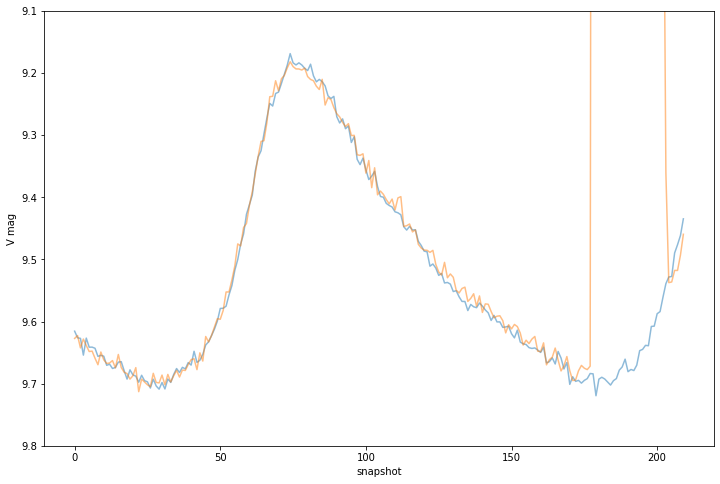

In [2]:
from utils import Star, plot_refresh

gain = 0.6
ron = 28.8
rad = [10.5,20,60]

file = np.array([], dtype=str)
sz_lyn_mag_1 = np.array([])
sz_lyn_mag_2 = np.array([])

for i in range(1,211):
#for i in range(130,140):

    
    # Load reduced image
    f = 'sci_2015/Reduced-%03i.fits' % i
    file = np.append(file, f)
    sci = fits.open(f)[0]
    
    sz_lyn = Star(sci.data, np.s_[250:380,400:530])
    sz_lyn.photometry(rad=rad)

    bjr_415 = Star(sci.data, np.s_[420:550,140:270])
    bjr_415.photometry(rad=rad)

    bjr_416 = Star(sci.data, np.s_[530:660,470:600])
    bjr_416.photometry(rad=rad)

    #plot_img(bjr_415.targ)
    #plot_img(bjr_415.bkg)

    bjr_415.mag = 10.924  # V
    bjr_416.mag = 11.456  # V

    sz_lyn.magnitude(bjr_415)
    sz_lyn_mag_1 = np.append(sz_lyn_mag_1, sz_lyn.mag)
    sz_lyn.magnitude(bjr_416)
    sz_lyn_mag_2 = np.append(sz_lyn_mag_2, sz_lyn.mag)
    
# Save the products
from astropy.table import Table
t = Table([file, sz_lyn_mag_1, sz_lyn_mag_2], 
           names=['file', 'V1', 'V2'])
t.write('sci_2015/mags_pre.fits', format='fits', overwrite=True)

plot_graph(sz_lyn_mag_1, xlabel='snapshot', ylabel='V mag', alpha=0.5)
plot_graph(sz_lyn_mag_2, new=False, alpha=0.5)
plt.ylim(9.8, 9.1)
plt.show()

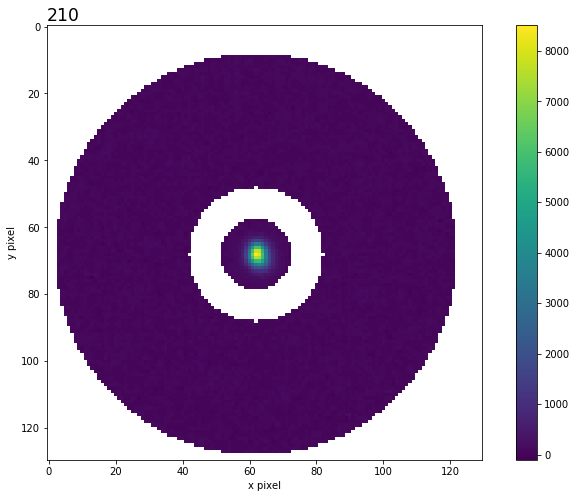

In [18]:
for i in range(170,211):
    f = 'sci_2015/Reduced-%03i.fits' % i
    file = np.append(file, f)
    sci = fits.open(f)[0]

    #bjr_416 = Star(sci.data, np.s_[530:660,470:600])
    #bjr_416.photometry(rad=rad)

    bjr_415 = Star(sci.data, np.s_[420:550,140:270])
    bjr_415.photometry(rad=rad)


    plot_img(bjr_415.both_img)
    plot_refresh(i)
    plt.show()

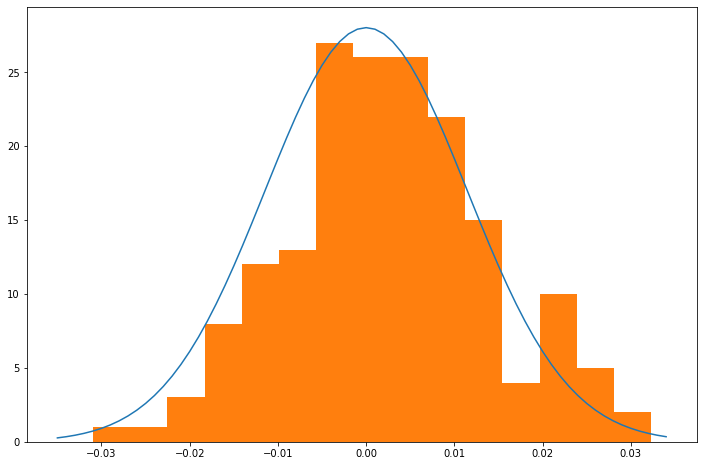

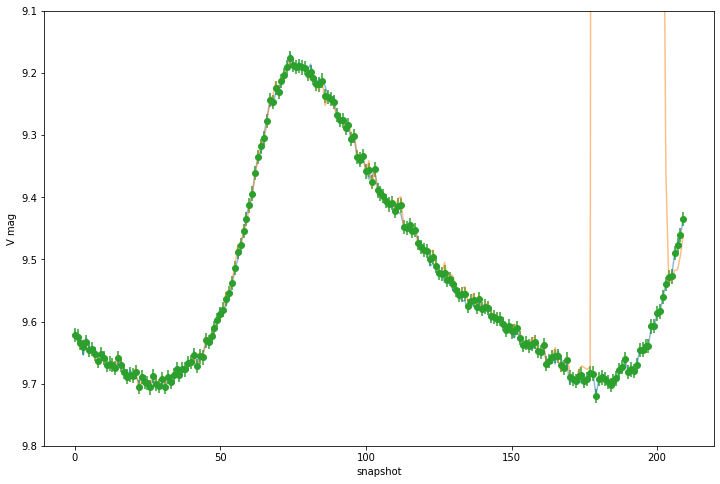

In [5]:
# Reload the products
mags = Table(fits.open('sci_2015/mags_pre.fits')[1].data)

# Define the cut, i.e. the last snapshot for which V2 is reliable
cut = 175
#mags = mags[:cut]

# Compute (running) average and standard deviation
# After the cut, we take only V1
mag = np.append(np.mean([mags['V1'][:cut], mags['V2'][:cut]], axis=0), mags['V1'][cut:])
mag_err = np.std([mags['V1'][:cut]-mags['V2'][:cut]])

bins = 15
x = np.arange(-0.035,0.035,0.001)
gauss = 1./(np.sqrt(2.*np.pi)*mag_err) * np.exp(-np.power(x/mag_err, 2.)/2)
gauss_norm = gauss * len(mag[:cut]) * (np.max(x)-np.min(x))/ bins

plot_graph(x, gauss_norm)
plt.hist(mags['V1'][:cut]-mags['V2'][:cut], bins=bins)
plt.show()

plot_graph(mags['V1'], xlabel='snapshot', ylabel='V mag', alpha=0.5)
plot_graph(mags['V2'], new=False, alpha=0.5)
plot_graph(mag, mode='errorbar', new=False, yerr=mag_err, fmt='o')
plt.ylim(9.8, 9.1)
plt.show()

from astropy.table import Table
t = Table([mags['file'], mag, [mag_err]*len(mags)], names=['file', 'V', 'V_err'])
t.write('sci_2015/mags.fits', format='fits', overwrite=True)